In [1]:
%matplotlib inline 

First, we must import the needed modules to load and work with the data.

In [2]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as colors
import gen_data

We will now simulate the data and package this information as it would come from Crowd-Sourcing Classifier (CC) on the Zooniverse server.

We have four sets of variables to create and discuss as we go through this notebook.

retired_images: A panda structure with columns 

    'imageID' (int) - ID of the image
    'class' (int) - the class the image was retired as

conf_matrices: A panda structure with columns 

    'userID' (int) - ID of the user
    'conf_matrix' (np.array) - the confusion matrix of the user

PP_matrices: A panda structure with columns 

    'imageID' (int) - ID of the image
    'pp_matrix' (np.array) - the prior (if it exists) of the image based on user evaluations

images: A panda structure with columns

    'type' (string) - A label, either 'T' or 'G', to determine if the image 
    is a ML classified label or a pre-labelled "golden" image

    'labels' (np.array) - A 1XN row vector where N is the number
    of labels this image has been given at a certain time. Each column
    is a different answer that is associated with a different user.
    This takes us to the next column

    'userIDs' (np.array) - A 1XN row vector where N is the number of labels 
    this image has been given. Each userID is associated with one label
    applied to the image in the labels column

    'ML_posterior' (np.array) - A 1XC row vector where C is the number of 
    pre-determined morphologies that the classifier has been trained on.
    Each column is the ML confidence that the image belongs in one of the C classes

    'truelabel' (int) - For images labelled 'T' this values is set to -1
    but for images labelled 'G' This value indicates the "true" class
    that this image belongs in for the purposes of comparing a citizens
    classification with this true label.
       
    'imageID' (int) - ID of the image


In [3]:
# retired images and PP_matrices starts out blank as we assume we have not seen any images at the outset of the CC. A
retired_images = pd.DataFrame({ 'imageID' : [], 'class' : []})
PP_matrices    = pd.DataFrame({ 'imageID' : [],'pp_matrix' : []})
images,conf_matrices = gen_data.gen_data()

Let's talk about the conf_matrices variable that stores the confusion matrices of all the users. This panda structure will be a NX2 array where N is the number of users. In each row, we have one column that contains the CXC "confusion matrix", where C is the number of classes, for that user and another that contains the ID of that user. A perfectly skilled user would only have values on the diagonal of this matrix and values of zero everywhere else. Values off of the diagonal indicate that the user gave an incorrect label to an image. Right or wrong answers are given with respect to either golden images which are pre-labelled images or to images that are retired through the pipeline. How we identify those images from the Zooniverse site that are in this "golden set" will come later. To illustrate this we'll print out one users simualted confusion matrix.

In [4]:
sample_conf_matrix = np.load('sample_conf_matrix.npy')
print(sample_conf_matrix) #print sample confusion matrix of a user

[[ 189.    5.    2.    5.    1.    1.    5.    2.    5.    3.    4.    2.
     4.    2.    1.]
 [   4.  182.    4.    1.    1.    2.    2.    2.    5.    3.    3.    3.
     1.    5.    4.]
 [   4.    4.  193.    3.    1.    3.    4.    4.    2.    5.    4.    5.
     5.    5.    1.]
 [   1.    3.    3.  195.    5.    1.    2.    3.    3.    5.    3.    5.
     4.    4.    3.]
 [   2.    3.    1.    1.  190.    2.    5.    3.    3.    4.    2.    2.
     4.    2.    1.]
 [   1.    3.    2.    2.    4.  206.    4.    5.    2.    1.    2.    5.
     5.    4.    4.]
 [   3.    3.    1.    2.    5.    5.  182.    5.    4.    2.    4.    1.
     5.    2.    3.]
 [   1.    4.    1.    5.    2.    5.    4.  218.    3.    3.    4.    2.
     1.    2.    5.]
 [   4.    5.    3.    1.    1.    4.    4.    5.  188.    1.    5.    4.
     4.    1.    3.]
 [   5.    2.    2.    3.    5.    1.    3.    5.    4.  214.    4.    4.
     5.    2.    2.]
 [   2.    1.    3.    1.    1.    2.    5.    4. 

For example, the value in the first row, second column is a 5. This indicates that the user classified 5 images in class 2, when the image was "retired", or placed in, class 1. Confusion matrices are used to indicate a user's skill level.

Here's a good visualization of the matrix in heat map form:

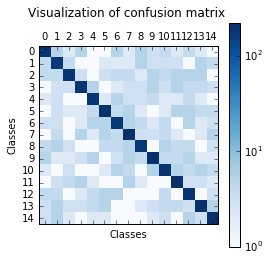

In [8]:
plt.matshow(sample_conf_matrix, cmap='Blues', norm=colors.LogNorm(vmin=sample_conf_matrix.min(), vmax=sample_conf_matrix.max()))
plt.colorbar()
plt.xlabel('Classes')
plt.ylabel('Classes')
plt.title('Visualization of confusion matrix \n')
ax = plt.gca()
ax.set_xticks(np.arange(0,15,1))
ax.set_yticks(np.arange(0,15,1))
plt.show()

As this heatmap changes everytime the notebook is run we can only make general comments. Ideally, the user would have a dark blue diagonal tiles and white tiles everywhere else. The darker the off-diagonal tiles are the worse user is at classifying. That being said, sometimes we can expect that a given class, say class 6, will have a dark blue spot along the diagonal where it intersects with column 6 and is otherwise white except for one other column which would indicate the other class that this user confuses class 6 with.

Now, we will define the main function that evaluates the images labeled by users. The Zooniverse server (specifically Nero https://github.com/zooniverse/nero) will send data which will be evaluated in batches. 

Lets look at the data we would expect to have for every image.

In [9]:
sample_image = pd.read_pickle('sample_image')
print(sample_image) #print data for sample image

type                                                            T
labels          [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1...
userIDs         [5, 2, 9, 22, 1, 23, 24, 21, 7, 0, 14, 3, 20, ...
ML_posterior    [0.0197605730029, 0.0197605730029, 0.019760573...
truelabel                                                      -1
imageID                                                       135
Name: 0, dtype: object


Okay, that's a lot of information for one image. Lets breakdown what each of these variables represents for a given image. In the next section, we will discuss various ways to access and utilize these panda structures.

In [10]:
print("imageID:", sample_image['imageID'], "\n")

print("userIDs:", sample_image['userIDs'], "\n")

print("labels:", sample_image['labels'])

imageID: 135 

userIDs: [ 5  2  9 22  1 23 24 21  7  0 14  3 20 18 19  6 13 15 25 17 11 16 10  8 12] 

labels: [12 12 12 12 12 12 12 12 12 12 12 12  6 12  1  4 11  8 10  6  6  1  8  0 13]


userIDs: the ID of the users who classified this image

imageID: the ID of the this image

labels: the classification made by the users for this image

In [11]:
print("type:", sample_image['type'], "\n")

print("ML_posterior:", sample_image['ML_posterior'], "\n")

print("true_label:", sample_image['truelabel'])

type: T 

ML_posterior: [ 0.01976057  0.01976057  0.01976057  0.01976057  0.01976057  0.01976057
  0.01976057  0.01976057  0.01976057  0.01976057  0.01976057  0.01976057
  0.72335198  0.01976057  0.01976057] 

true_label: -1


What does all this information mean?

This image has type 'T', meaning it is NOT a golden image and has only received labelling from the Machine Learning Classifier. If the type was 'G', then this image has been pre-labelled.

From the ML_posterior matrix, we can see that the Machine Learning classifer is 79.95% sure this image is in the 14th class, and  1.43% sure it is in each other class.

true_label mainly has meaning for images that have been pre-labelled. If it has been pre-labelled then it has a class associated with it already. If it has not been pre-labelled, we assign a label of -1.

Now that we understand the structure of 'images' and how to access specific image information, lets move on to evaluating image and user classifications.

In [26]:
print images.iloc[-1,:]['type'], "\n"

print images.iloc[-1,:]['truelabel'], "\n"

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-26-89a0b26db994>, line 1)

Initialize R_lim, the limit on how many people can look at an image, and it is not retired, before it is passed onto a higher skill level

In [12]:
R_lim = 23

Initialize N, the number of images in a batch

In [13]:
N = images['type'].size

Initialize C, the number of morphologies (classes)

In [14]:
 for i in range(N):
        if images['type'][i] == 'T':
            C = images['ML_posterior'][i].size
            break

Initialize a flat prior. Essentially this means before any more information is known, we assume each image has an equal probability of being in each of the 15 classes

In [22]:
priors = np.ones((1,C))/C
print(priors)

[[ 0.06666667  0.06666667  0.06666667  0.06666667  0.06666667  0.06666667
   0.06666667  0.06666667  0.06666667  0.06666667  0.06666667  0.06666667
   0.06666667  0.06666667  0.06666667]]


In [16]:
t = .4*np.ones((C,1))

Initialize a matrix that holds the decision for each image

In [17]:
 dec_matrix = np.zeros((1,N))

Initialize a matrix that holds the true labels of each image. (corresponds one to one to decision matrix)

In [18]:
class_matrix = np.zeros((1,N))

Initialize a list to hold the pp_matrices for each images. We'll talk about the importance of pp_matrices later. Note that pp_matrix and posterior matrix may be used interchangeably. 

In [19]:
pp_matrices_rack = []

Now lets look at how a decision for an image is made. The decider function takes in an image's posterior matrix, machine learning decision, number of annotators, and R_lim as arguments, and uses that information to decide the next step for the image.

In [20]:
def decider(pp_matrix, ML_dec, t, R_lim, num_annotators): #define the decider function with given arguments
    pp_matrix2 = np.hstack((pp_matrix, ML_dec.reshape((15,1)))) #Include ML_decision in posterior matrix
    v = np.sum(pp_matrix2, axis=1)/np.sum(np.sum(pp_matrix)) #create vector of normalized sums of pp_matrix2 
    maximum = np.amax(v) #initialize maximum, max value of v
    maxIdx = np.argmax(v) #initialize maxIdx, index of max value of v

    if maximum >= t[maxIdx]: #if maximum is above threshold for that specific class

        decision = 1 #retire the image
        print('Image is retired')

    elif num_annotators >= R_lim: #if more than R_lim annotators have looked at image and no decision reached

        decision = 2 #pass image on to next user skill class
        print('Image is given to the upper class')

    else: #if fewer than R_lim annotators have looked at image

        decision = 3 #keep image in same class
        print('More labels are needed for the image')

    image_class = maxIdx #set image_class 

    return decision, image_class #return the decision, and image class

The next chunk of code is used to update users confusion matrices, images posterior matrices (PP_matrix), and to make decisions on the future of an image.

In [23]:
    for i in range(N):

        if images['type'][i] == 'G': #check if golden set image
            labels  = images['labels'][i] #take citizen labels of image
            userIDs = images['userIDs'][i] #take IDs of citizens who label image
            tlabel  = images['truelabel'][i] #take true label of image

            for ii in range(userIDs.size): #iterate over user IDs of image

                indicator = 0

                for cc in range(len(conf_matrices)): #iterate over confusion matrices

                    if userIDs[ii] == conf_matrices['userID'][cc]: #if user is registered

                        #take confusion matrix of citizen and index by true label, label given by user and update the confusion matrix at that entry.
                        conf_matrices['conf_matrix'][cc][tlabel,labels[ii]] += 1
                        indicator = 1

                if indicator == 0: #if user not registered

                    dummy_matrix = np.zeros((C,C)) #create dummy matrix
                    dummy_matrix[tlabel,labels[ii]] += 1 #update dummy matrix
                    tmp = pd.DataFrame({ 'userID' : [userIDs[ii]],'conf_matrix' : [dummy_matrix]},index = [len(conf_matrices)])
                    conf_matrices = conf_matrices.append(tmp)

            dec_matrix[0,i] = 0 #since it is a training image, no decision is made
            class_matrix[0,i] = tlabel #class of image is its true label
            pp_matrices_rack.append([0])
            print('The image is from the training set')

        else: #if image not in golden set, i.e. has ML label but no true label

            indicator1 = 0

            for kk in range(len(retired_images)): #loop over retired images

                if images['imageID'][i] == retired_images['imageID'][kk]: #if image is retired
                    indicator1 = 1
                    dec_matrix[0,i] = -1 #give invalid decision
                    pp_matrices_rack.append([0])
                    break

            if indicator1 == 0: #if image is not retired

                labels           = images['labels'][i] #take citizen labels of image
                userIDs          = images['userIDs'][i] #take IDs of citizens who label image
                num_annotators   = labels.size #define number of citizens who annotate image
                ML_dec           = images['ML_posterior'][i] #take ML posteriors of image
                imageID          = images['imageID'][i] #take ID of image
                image_prior      = priors #set priors for image to original priors

                for y in range(len(PP_matrices)): #iterate over posterior matrices

                    if imageID == PP_matrices['imageID'][y]: #find posterior matrix for the image
                        image_prior = np.sum(PP_matrices['pp_matrix'][y],axis=1)/np.sum(PP_matrices['pp_matrix'][y]) #if image labeled but not retired, PP_matrix information is used in the place of priors
                        break

                pp_matrix = np.zeros((C,num_annotators)) #create posterior matrix
                
                for k in range(num_annotators): #iterate over citizens that labeled image
                    for iN in range(len(conf_matrices)): #iterate over confusion matrices

                        if userIDs[k] == conf_matrices['userID'][iN]: #find confusion matrix corresponding to citizen

                            conf = conf_matrices['conf_matrix'][iN] #take confusion matrix of citizen
                            break

                    conf_divided,x,z,s = np.linalg.lstsq(np.diag(sum(conf,2)),conf) #calculate p(l|j) value

                    for j in range(C): #iterate over classes

                        pp_matrix[j,k] = (conf_divided[j,labels[k]]*priors[0][j])/sum(conf_divided[:,labels[k]]*priors[0]) #calculate posteriors
                pp_matrices_rack.append(pp_matrix) #assign values to pp_matrices_rack


                dec_matrix[0,i], class_matrix[0,i] = decider(pp_matrix, ML_dec, t, R_lim, num_annotators) #make decisions for each image in batch
    for i in range(N):
        if dec_matrix[0,i] == 1: #if image is retired
            labels = images['labels'][i] #the citizen label of the image is taken
            userIDs = images['userIDs'][i] #the IDs of the citizens that labeld that image are taken
            for ii in range(userIDs.size): #iterate over user IDs of image

                indicator2 = 0

                for cc in range(len(conf_matrices)): #iterate over confusion matrices

                    if userIDs[ii] == conf_matrices['userID'][cc]: #if user is registered

                        #take confusion matrix of citizen and index by true label, label given by user and update the confusion matrix at that entry.
                        conf_matrices['conf_matrix'][cc][tlabel,labels[ii]] += 1
                        indicator2 = 1

                if indicator2 == 0: #if user not registered

                    dummy_matrix = np.zeros((C,C)) #create dummy matrix
                    dummy_matrix[tlabel,labels[ii]] += 1 #update dummy matrix
                    tmp = pd.DataFrame({ 'userID' : [userIDs[ii]],'conf_matrix' : [dummy_matrix]},index = [len(conf_matrices)])
                    conf_matrices = conf_matrices.append(tmp)

    # Ordering the images and sending/saving them
    counter1 = len(retired_images)
    counter2 = len(PP_matrices)

    for i in range(N):

        if dec_matrix[0,i] == 1: # if it is decided to be retired
            tmp = pd.DataFrame({ 'imageID' : [images['imageID'][i]],'class' : [class_matrix[0,i]]},index = [counter1])
            retired_images = retired_images.append(tmp)

            counter1 = counter1 + 1

        elif dec_matrix[0,i] == 2 or dec_matrix[0,i] == 3:  #if the decision is forwarding to the upper class or wait for more labels

            dummy_decider = 1

            for y in range(len(PP_matrices)):        #in case the image was waiting for more labels beforehand

                if images['imageID'][i] == PP_matrices['imageID'][y]:
                    PP_matrices['pp_matrix'][y] = pp_matrices_rack[i]      #the PP matrix is overwritten.
                    dummy_decider = 0
                    break

            if dummy_decider:
                tmp = pd.DataFrame({ 'imageID' : [images['imageID'][i]],'pp_matrix' : [pp_matrices_rack[i]]},index = [counter2])
                PP_matrices = PP_matrices.append(tmp)

                counter2 = counter2 + 1

Image is retired
Image is retired
Image is retired
Image is retired
Image is retired
Image is given to the upper class
Image is retired
Image is given to the upper class
Image is retired
Image is retired
Image is retired
Image is retired
Image is given to the upper class
Image is retired
Image is retired
Image is retired
Image is retired
Image is retired
Image is given to the upper class
Image is retired
Image is retired
Image is retired
Image is retired
Image is given to the upper class
Image is given to the upper class
Image is retired
Image is retired
Image is given to the upper class
Image is retired
Image is retired
Image is retired
Image is retired
Image is retired
Image is retired
Image is given to the upper class
Image is retired
Image is retired
Image is retired
Image is retired
Image is given to the upper class
Image is retired
Image is retired
Image is retired
Image is given to the upper class
Image is retired
Image is given to the upper class
Image is retired
Image is retir

Now lets take a look at how the decider function works:

In [24]:
#Sample arguments for decider function 
pp_matrix_sample = PP_matrices['pp_matrix'][0]
ML_dec_sample = np.array([.1, .05, .05, .05, .05, .6, .001, .014, .1, .002, .005, .0002, 0, 0, 0])
R_lim_sample = 20
no_annotators_sample = len(PP_matrices['pp_matrix'][0][0])

decider(pp_matrix_sample, ML_dec_sample, t, R_lim_sample, no_annotators_sample) #call decider function with sample arguments

Image is given to the upper class


(2, 3)